# Procesamiento de Lenguaje Natural | Análisis de Sentimientos con Twitter (es)

## Importar librerías

In [1]:
!pip install pyprind

In [2]:
import os
import sys
import tarfile
import time
import re
import pyprind
import numpy as np
import pandas as pd

In [3]:
import tweepy as tw

### Habilitar Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Obtener permisos de la API de Twetter

In [5]:
consumer_key = 'u9wwsCjQq7BgY6MVTyMMrWCTD'
consumer_secret = '15fch9r8e8FokSnV5tUbyBkHvl0c3ggfJO1XoR0pMsRrORznyB'
access_token = '1358586629770928139-tKoBpNFnxWxV9ROmji8LJ1npKpHxky'
access_token_secret = 'AERm0fJt2WClhZe4YxIs66I1A3RtDcbw3Ej9cYcWO85bq'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth, wait_on_rate_limit=True)

## Obtener tweets

### Marvel Studios

In [ ]:
search_words = '#MarvelStudios' + '-filter:retweets'
date_since = '2020-01-01'

tweets = tw.Cursor(api.search, search_words, 'es', date_since).items(10000)

In [ ]:
data = [[tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

tw_df = pd.DataFrame(data=data, columns=['User', 'Location', 'Text'])
tw_df

,User,Location,Text
0,IaMysteR,México,"Según el medio #Geekosity, #MarvelStudios le h..."
1,Shankusuno,España,¡Filtraciones Marvel! ¡Norman Osborn es el con...
2,SMASHem_mx,,¡Por fin sabemos cuándo podremos ver Ant-Man a...
3,pam_podcast,"Distrito Federal, México",Relanzando la fase 4 del #MCU ..... y las seri...
4,federico_sykes,Capital Federal,La segunda película del Mundo Marvel (en orden...
...,...,...,...
1562,AluenMarouf,Chile,Recuerden que este año aún nos queda ver a otr...
1563,WhitOutAccount,. -. / .- .-.. --. ..- -. .- /,En mi opinión sería un buen título para la pel...
1564,charlietv_ok89,"Canelones, Uruguay 🇺🇾",El escritor principal y creador de Disney + y ...
1565,ArtSanara,,bruja escarlata/scarlet witch. Comisiones abie...


In [ ]:
tw_df.to_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Marvel/Marvel_Studios.csv', index=False, encoding='utf-8')

### SOS Colombia DDHH

In [6]:
search_words = '#ParoNacional29A' + '-filter:retweets'
date_since = '2020-01-01'

tweets = tw.Cursor(api.search, search_words, 'es', date_since).items(5000)

In [7]:
data = [[tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

tw_df = pd.DataFrame(data=data, columns=['User', 'Location', 'Text'])
tw_df

,User,Location,Text
0,johamos06,,Estoy totalmente de acuerdo con el #ParoNacion...
1,eseljeexx,España,Mrc ya no se trata de si la arepa es de Colomb...
2,BambamSteven_,Puerto Wilches - Pamplona,"El pueblo no mata al pueblo, es increíble lo q..."
3,Davidhern10,"Barcelona, España","Estado paramilitar, estado Genocida. Me duele ..."
4,edgardoalcendra,Colombia,Se metieron con la generación que todo lo grab...
...,...,...,...
4995,PretorianosNews,,"Ante el continuo saqueo algunos ""ciudadanos"" h..."
4996,NicolleSM,España,"Que no pare la lucha, hay que seguir y no rend..."
4997,su_fusil,,#ElParoContinua29A \n#ParoNacional29A Este frí...
4998,lukaglitter,she!her ⇨Read carrd BYF ᵕ̈,No suelo hablar de ideologías ni nada de eso e...


In [8]:
tw_df.to_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Colombia/Paro_Nacional.csv', index=False, encoding='utf-8')

## Obtener Corpus: Corvertir XML a CSV

In [22]:
import xml.etree.ElementTree as etree
import csv
from os import scandir
from sklearn.model_selection import train_test_split

### Función para listar archivos de un directorio

In [23]:
def files_of_path(path):
    return [obj.name for obj in os.scandir(path) if obj.is_file()]

files = files_of_path('/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017')

for file in files:
    print(file)

### Función para convertir listas a archivos CSV

In [24]:
def list_to_csv(data, filename):
    with open(filename, 'w', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', lineterminator='\n', quoting=csv.QUOTE_NONNUMERIC)
        writer.writerows(data)

### Función para cargar de un CSV a una Lista (messages | labels)

In [25]:
def csv_to_lists(filename):
    messages = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            messages.append(row[1])
            labels.append(row[2])
    return messages, labels

### Función para parsear xml en un dataframe

#### corpus de general tweetid | content | sentiments/polarity/value

In [26]:
def general_tass_2017_to_list(filename, qrel=None):
    tree = etree.parse(filename)
    root = tree.getroot()
    data = []

    for tweet in root:
        tweetId = tweet.find('tweetid').text
        content = tweet.find('content').text
        polarityValue = qrel[tweetId]
        data.append([tweetId, content.replace('\n', ' '), polarityValue])
    
    return data

#### corpus politics tweetid | content | sentiments/polarity

In [27]:
def politics_tass_to_list(filename):
    tree = etree.parse(filename)
    root = tree.getroot()
    data = []

    for tweet in root:
        tweetId = tweet.find('tweetid').text
        content = tweet.find('content').text
        aux = next((e for e in tweet.findall('sentiments/polarity') if e.find('entity') == None), None)
        if aux != None:
            polarityValue = aux.find('value').text
            data.append([tweetId, content.replace('\n', ' '), polarityValue])
    return data

#### corpus de internacional tweetid | content | sentiments/polarity/value

In [28]:
def intertass_tass_to_list(filename, qrel=None):
    tree = etree.parse(filename)
    root = tree.getroot()
    data = []

    for tweet in root:
        tweetId = tweet.find('tweetid').text
        content = tweet.find('content').text
        polarityValue = tweet.find('sentiment/polarity/value').text
        if polarityValue == None:
            polarityValue = qrel[tweetId]
            data.append([tweetId, content.replace('\n', ' '), polarityValue])
    return data

#### Funcion para unir los tweets corpus general test con sus sentiments

In [29]:
def gold_standard_to_dict(filename):
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        data = {rows[0]: rows[1] for rows in reader}
    return data

### Función para separar el 100% del corpus entre Train(70%) y Test(30%)

In [30]:
 def generate_train_test_subsets(data, size):
     codes = [d[0] for d in data]
     labels = [d[2] for d in data]
     codes_train, codes_test, labels_train, label_test = train_test_split(codes, labels, train_size=size)
     train_data = [d for d in data if d[0] in codes_train]
     test_data = [d for d in data if d[0] in codes_test]
     return train_data, test_data

## Ejecutar cada función de parsear los copus y guardarlo en un CSV(full, train, test)

In [31]:
data = []

### Parceamos el internacional TASS

Tomamos el corpus internacional (test) y generamos una lista de ID del tweet y el sentimiento para agregarlo a la data

In [32]:
qrel = gold_standard_to_dict('/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/InterTASS/InterTASS_Test_res.qrel')

Como el test del corpus internacional esta sin los sentimientos, es necesario agregarlos

In [33]:
data.extend(intertass_tass_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/InterTASS/InterTASS_Test.xml', 
    qrel
))

data.extend(intertass_tass_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/InterTASS/InterTASS_development.xml'
))

data.extend(intertass_tass_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/InterTASS/InterTASS_Training.xml'   
))

### Parceamos el general TASS

In [34]:
qrel = gold_standard_to_dict('/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/General Corpus of TASS/general-sentiment-3l.qrel')

In [35]:
data.extend(general_tass_2017_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2017/General Corpus of TASS/general-tweets-test.xml',
    qrel
))

### Parceamos el STOMPOL (política) TASS_2014 

In [36]:
data.extend(politics_tass_to_list(
    '/content/drive/MyDrive/Colab Notebooks/PLN/Corpus/Spanish/tass_2014/politics-test-tagged.xml'
))

### Separamos la data en Train y Test

In [37]:
train, test = (generate_train_test_subsets(data, size=0.3))

In [38]:
list_to_csv(data, '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full.csv')
list_to_csv(train, '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_train.csv')
list_to_csv(test, '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_test.csv')

## Preprocesamiento del corpus

### Cargar librerías necesarias

In [16]:
import re
from nltk import TweetTokenizer
from nltk.stem import SnowballStemmer

|Librería|Función|
|--------|-------|
|re|Operaciones regulares para la búsqueda y manipulación de cadenas|
|TweetTokenizer|Librería para tokenizar|
|SnowballStemmer|Algoritmo para clasificación de palabras|

Varaibles para mejorar la escritura (opcional)

In [39]:
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'twlaugh'

Definir que el algortimo de clasificación use el idimoa español

In [40]:
_stemmer = SnowballStemmer('spanish')

Definir una variable para la funcipon de tokenizar (opcional)

In [17]:
_tokenizer = TweetTokenizer().tokenize

Variable para definir si quiero normalizar o eliminar: remove los hashtag, menciones y urls en los tweets

In [41]:
_twitter_features = 'normalize'

Variable para definir si se desea convertir o no a la raiz de la palabra

In [42]:
_stemming = False

### Funciones / métodos de preprocesamiento

#### Listas de Conversión (Quitar tildes y palabras coloquiales)

Lista de conversión para quitar las tildes a las vocales

In [43]:
DIACRITICAL_VOWELS = [('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ü', 'u')]

Lista para corregir algunas palabras coloquiales / jerga en español (palabras básicas)

In [44]:
SLANG = [('d', 'de'), ('(q|k)', 'que'), ('[qk]', 'que'), ('xo', 'pero'), ('xa', 'para'), 
         ('[xq]', 'porque'), ('fvr', 'favor'), ('(xfa|xf|pf|plis|pls|porfa)', 'por favor'),
         ('dnd', 'donde'), ('tb', 'tambien'), ('(tq|tk)', 'te quiero'), ('tqm', 'te quiero mucho'),
         ('x', 'por'), ('\+', 'mas'), ('maso', 'mas o menos'), ('(holi|hl)', 'hola'), 
         ('wnas', 'buenas'), ('nd', 'nada'), ('msj', 'mensaje'), ('es3', 'estre'), ('tp', 'tampoco'), 
         ('(wno|weno|bn)', 'bueno'), ('DM', 'mensaje directo'), ('BFF', 'mejores amigos para siempre'),
         ('OMG', 'Oh Dios mio'), ('TBT', 'jueves de vuelta al pasado')]

#### Función / método de normalización de risas

In [45]:
def normalize_laughs(message):
    message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
    message = re.sub(r'\b(?=\w*[k])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
    message = re.sub(r'\b(?=\w*[h])[aeiouh]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
    message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
    return message

In [46]:
print(normalize_laughs('jajaja, jejeje, Lol, hohoho, kokoko'))

twlaugh, twlaugh, twlaugh, twlaugh, twlaugh


#### Función / método para eliminar o normalizar menciones, hashtags y URL de un mensaje (tweet)

In [47]:
def process_twiter_features(message, twitter_features):
    message = re.sub(r'[\.\,]http', '. http', message, flags=re.IGNORECASE)
    message = re.sub(r'[\.\,]#', '. #', message)
    message = re.sub(r'[\.\,]@', '. @', message)
    if twitter_features == REMOVE:
        # Eliminar menciones, hashtags y URL
        message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
        message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
    elif twitter_features == NORMALIZE:
        # Cuando sea necesario se normalizaran las menciones, hashtags y URL
        message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
        message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
        message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)
    return message

In [48]:
print(process_twiter_features('@MarvelStudios, #MarvelStudios, https://marvelstudios.com', 'normalize'))

twmention twhashtag twurl


#### Función / método general para el preprocesamiento

In [49]:
def preprocess(message):
    message = message.lower()

    # Eliminar números, retorno de línea y los retweet(antiguos estilos de twitter)
    message = re.sub(r'(\d+|\n|\brt\b)', '', message)

    # Eliminar vocales con signos diacríticos (posibles ambigüedades)
    for s,t in DIACRITICAL_VOWELS:
        message = re.sub(r'{0}'.format(s), t, message)

    # Eliminar caracteres repetidos
    message = re.sub(r'(.)\1{2,}', r'\1\1', message)
    
    # Normalizar las risas
    message = normalize_laughs(message)

    # Traducir la jerga y terminos coloquiales sobre todo en el español
    for s,t in SLANG:
        message = re.sub(r'\b{0}\b'.format(s), t, message)
    
    # Normalizar - eliminar hashtags, menciones y URL
    message = process_twiter_features(message, _twitter_features)

    # Convertir las palabras a su raiz (Bonito, Bonita --> bonit)
    if _stemming: 
        message = ' '.join(_stemer.stem(w) for w in _tokenizer(message))

    return message

In [50]:
print(preprocess("jajaja, @MarvelStudios, #MarvelStudios, https://www.marvel.com/movies"))

twlaugh, twmention twhashtag twurl


### Descargar las librerías NLTK

Descargamos la librería de stopwords

In [51]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Cargamos el CSV del corpus

### Aplicamos preprocesamiento al CSV y creamos un nuevo CSV limplio

In [52]:
df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full.csv',
    encoding='utf-8')

Asignamos nombres a las columnas del csv para facilitar la búsqueda de información

In [53]:
df.columns = ['tweetid', 'tweet', 'sentiment']

Aplicamos el preprocesamiento a los tweets con steaming = False

In [54]:
df['tweet'] = df['tweet'].apply(preprocess)

Eliminamos la columna tweetid que no nos sirve para entrenar y si genera más uso de memoria

In [55]:
df = df.drop(columns='tweetid')

Es mejor trabajar con valores enteros que con letras, por lo tanto reemplazaremos los sentimientos que estan como:

|Valor Actual|Nuevo Valor|
|------------|-----------|
|NONE|-1|
|NEU|0|
|P|1|
|N|2|

In [56]:
df.loc[df['sentiment'] == 'NONE', 'sentiment'] = '-1'
df.loc[df['sentiment'] == 'NEU', 'sentiment'] = '0'
df.loc[df['sentiment'] == 'P', 'sentiment'] = '1'
df.loc[df['sentiment'] == 'N', 'sentiment'] = '2'
df['sentiment'].unique()

array(['1', '2', '-1', '0'], dtype=object)

Guardamos el dataset en un nuevo CSV para facilitar su posterior uso

In [57]:
df.to_csv(
    '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full_clean.csv', 
    index=False, 
    encoding='utf-8')

## Entrenar el modelo de aprendizaje

### Funciones para tokenizar y extraer tweets

#### Función para tokenizar y limpiar

In [21]:
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

#### Función para extraer un documento del dataset

In [58]:
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)       # Skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

#### Función que tomara una secuencia de documentos y devolvera un número particular de documentos

In [59]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [60]:
next(stream_docs(path='/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full_clean.csv'))

('twmention ya era hora de volver al csgo y dejares el padel bienvenida ', 1)

## Entrenamos el modelo con regresión logística

In [61]:
path = '/content/drive/MyDrive/Colab Notebooks/PLN/dataset_2017_full_clean.csv'

Definimos una versión liviana de CountVectorizer + TfidfVectorizer llamada HashingVectorizer

In [14]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

In [19]:
vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Definimos como algoritmo la regresión logística en el descenso gradiente

In [62]:
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path)

Entrenamiento

In [63]:
from nltk.corpus import stopwords
stop = stopwords.words('spanish')

Definimos las clases con las cuales vamos a entrenar

In [64]:
classes = np.array([-1, 0, 1, 2])

In [65]:
pbar = pyprind.ProgBar(50)

for _ in range(50):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Probamos la eficiencia del modelo con 5000 tweets

In [66]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)

In [67]:
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.805


Recalibramos el modelo

In [68]:
clf = clf.partial_fit(X_test, y_test)

## Serializamos / Congelamos el modelo para usarlo fuera de Google Colaboratory

In [9]:
import pickle

Creamos una carpeta en el drive para guardar los archivos serializados

In [69]:
dest = os.path.join('/content/drive/MyDrive/Colab Notebooks/PLN/TwitterClassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

Convertimos el clasificador y el stopword en archivo/objetos pkl. Es importante verificar que si se encuentran en dicho directorio

In [70]:
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

Para probar si funciona, cambiamos la basepath (directorio por defecto) de Python a la carpeta de TwitterClassifier

In [71]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/PLN/TwitterClassifier')

Deserializamos los estimadores

In [72]:
clf = pickle.load(
    open(
        os.path.join('/content/drive/MyDrive/Colab Notebooks/PLN/TwitterClassifier/pkl_objects', 
                     'classifier.pkl'), 
         'rb'))

Clasifiquemos un texto de ejemplo

In [73]:
label = {-1:'Sin sentimientos', 0:'Neutro', 1:'Positivo', 2:'Negativo'}

In [74]:
frase = 'Estoy alegre por las nuevas producciones de Marvel'
example = [frase]

Convertimos el texto en un vecot de palabras y extraemos sus caracteristicas https://scikit-learn.org/stable/modules/feature_extraction.html

In [75]:
textConvert = vect.transform(example)

print('Predicción: %s \nProbabilidad: %.2f%%' % (label[clf.predict(textConvert)[0]], np.max(clf.predict_proba(textConvert))*100))
print('Predicción: %s' % label[clf.predict(textConvert)[0]])
print(np.max(clf.predict_proba(textConvert))*100)

Predicción: Positivo 
Probabilidad: 68.88%
Predicción: Positivo
68.87750628463914


## Recorremos los tweets descargados y los clasificamos

In [ ]:
pbar = pyprind.ProgBar(50000)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Marvel/Marvel_Studios.csv', encoding='utf-8')

Creamos una columna llamada Sentiment donde guardamos la predicción y otra columna llamada Probability donde almacenaremos la acertabilidad que dio el clasificador

In [ ]:
df['sentiment'] = ''
df['probability'] = 0

Conversion de sentimientos (números a palabras)

In [ ]:
for rowid in range(len(df.index)):
    text = df['Text'][rowid]
    textConvert = vect.transform([text])
    df['sentiment'][rowid] = label[clf.predict(textConvert)[0]]
    df['probability'][rowid] = np.max(clf.predict_proba(textConvert))*100
    pbar.update()
df.head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,User,Location,Text,sentiment,probability
0,WipyTV,Mexico,¿Veremos un anuncio de #MarvelStudios después?...,Positivo,64
1,jorgemariozj,"Medellín, Colombia",¿Sabes que super héroes son?\n#lashistorietasd...,Positivo,69
2,p_secta,NaN,#TonyStark #MarvelStudios #Marvel Te extraño 😔...,Positivo,65
3,RockySantanaTo1,NaN,La mejor escena post-credito de #MarvelStudios...,Positivo,80
4,EPiscinazo,NaN,Quedará muy poca gente que no haya visto las p...,Positivo,64
5,Maestro_Ciego,Barcelona,Vamos a repasar en el #MateACiegas de esta sem...,Positivo,77
6,guatemovie,Guatemala,"Según el CEO de #MarvelStudios, #KevinFeige, #...",Positivo,68
7,ElPochocleroOk,Buenos Aires City Region,#AndrewGarfield negó rotundamente su participa...,Positivo,66
8,MaikStrange,Peru,Captain Marvel 2 cambia de nombre a #TheMarvel...,Positivo,64
9,MaikStrange,Peru,Captain Marvel 2 cambia de nombre a #TheMarvel...,Positivo,64


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Marvel/Marvel_Studios_sentiment.csv', index=False, encoding='utf-8')

Segunda forma de ejecutar el análisis (métodos)

In [ ]:
def f_prediction(row):
  text = row['Text']
  textConvert = vect.transform([text]) 
  return label[clf.predict(textConvert)[0]]

In [ ]:
def f_probability(row):
  text = row['Text']
  textConvert = vect.transform([text]) 
  return np.max(clf.predict_proba(textConvert))*100

In [ ]:
df["sentiment"] = df.apply(f_prediction, axis=1) # recorriendo columnas
df["probability"] = df.apply(f_probability, axis=1) # recorriendo columnas

sentiment
Negativo      10
Positivo    1552
dtype: int64


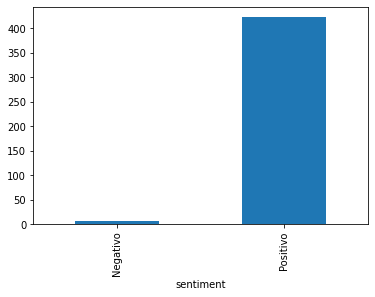

In [ ]:
import matplotlib.pyplot as plt

df.groupby('sentiment')['Location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
plt.show()

## Recorremos los tweets descargados y los clasificamos

In [76]:
pbar = pyprind.ProgBar(50000)

In [78]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Colombia/Paro_Nacional.csv', encoding='utf-8')

Creamos una columna llamada Sentiment donde guardamos la predicción y otra columna llamada Probability donde almacenaremos la acertabilidad que dio el clasificador

In [79]:
df['sentiment'] = ''
df['probability'] = 0

Conversion de sentimientos (números a palabras)

In [80]:
for rowid in range(len(df.index)):
    text = df['Text'][rowid]
    textConvert = vect.transform([text])
    df['sentiment'][rowid] = label[clf.predict(textConvert)[0]]
    df['probability'][rowid] = np.max(clf.predict_proba(textConvert))*100
    pbar.update()
df.head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
0% [###                           ] 100% | ETA: 00:39:11

,User,Location,Text,sentiment,probability
0,johamos06,NaN,Estoy totalmente de acuerdo con el #ParoNacion...,Positivo,54
1,eseljeexx,España,Mrc ya no se trata de si la arepa es de Colomb...,Positivo,72
2,BambamSteven_,Puerto Wilches - Pamplona,"El pueblo no mata al pueblo, es increíble lo q...",Positivo,64
3,Davidhern10,"Barcelona, España","Estado paramilitar, estado Genocida. Me duele ...",Positivo,58
4,edgardoalcendra,Colombia,Se metieron con la generación que todo lo grab...,Positivo,60
5,EstherJinete,Colombia,@HFCardonaG No puedo creer que alguien que sie...,Positivo,67
6,nicolastorrest6,NaN,El día de hoy en Colombia es como jugar monopo...,Positivo,77
7,andreah22735593,Argentina,En Medellín en este momento en el@parque de la...,Positivo,69
8,Alejand72037901,"Bogotá, D.C., Colombia",Me le paro a ese man y le aplaudo. Chico desco...,Negativo,53
9,RugeJaimes,"Bogotá, D.C., Colombia",Voy en bus a soacha y vengo escuchando una con...,Positivo,73


In [81]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/PLN/Colombia/Paro_Nacional_sentiment.csv', index=False, encoding='utf-8')

Segunda forma de ejecutar el análisis (métodos)

In [82]:
def f_prediction(row):
  text = row['Text']
  textConvert = vect.transform([text]) 
  return label[clf.predict(textConvert)[0]]

In [83]:
def f_probability(row):
  text = row['Text']
  textConvert = vect.transform([text]) 
  return np.max(clf.predict_proba(textConvert))*100

In [84]:
df["sentiment"] = df.apply(f_prediction, axis=1) # recorriendo columnas
df["probability"] = df.apply(f_probability, axis=1) # recorriendo columnas

sentiment
Negativo     891
Positivo    4109
dtype: int64


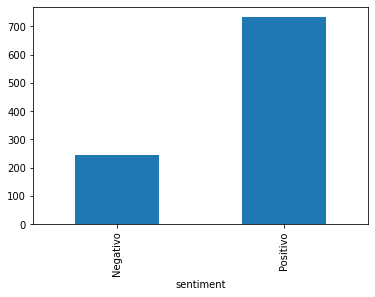

In [85]:
import matplotlib.pyplot as plt

df.groupby('sentiment')['Location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
plt.show()

## Hacer uso de SQLite

### Generar DB de sqlite

In [ ]:
import sqlite3
import os

if os.path.exists('tweets.sqlite'):
    os.remove('tweets.sqlite')

conn = sqlite3.connect('tweets.sqlite')
c = conn.cursor()
c.execute('CREATE TABLE tweets_db (tweet TEXT, sentiment INTEGER, date TEXT)')

example1 = 'que aburrido es estar en cuarentena…'
c.execute("INSERT INTO tweets_db (tweet, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example1, 2))

example2 = 'Estoy feliz de estar con mi familia'
c.execute("INSERT INTO tweets_db (tweet, sentiment, date) VALUES (?, ?, DATETIME('now'))", (example2, 1))

conn.commit()
conn.close()

### Consultar la DB

In [ ]:
conn = sqlite3.connect('tweets.sqlite')
c = conn.cursor()

c.execute("SELECT * FROM tweets_db WHERE date BETWEEN '2019-01-01 10:10:10' AND DATETIME('now')")
results = c.fetchall()
conn.close()

print(results)

[('que aburrido es estar en cuarentena…', 2, '2021-05-04 21:38:32'), ('Estoy feliz de estar con mi familia', 1, '2021-05-04 21:38:32')]
